# Trip Advisor review rating prediction

The task is to predict the rating based on the review content

### Initial Setup

In [68]:
import os
import pandas as pd
import regex as re

import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from nltk import FreqDist


Let's read our data

In [69]:
df = pd.read_csv(os.path.join("data", "tripadvisor_hotel_reviews.csv"))

df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


As we can see, the data format is pretty simple. We have a "Review" column, which contains the text of the review, and a "Rating" column, which contains a numeric Rating for each review


### Data Analysis

In this section, we need to analyse our data, understand it and get useful insights that can be used in the feature engineering step

Firstly, we're going to see a short description of the dataset

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


Here we can see, that we have 20491 reviews and there is no missing data

We need to check whether our target feature "Rating" is balanced or not. We can do it by looking at the target feature distribution

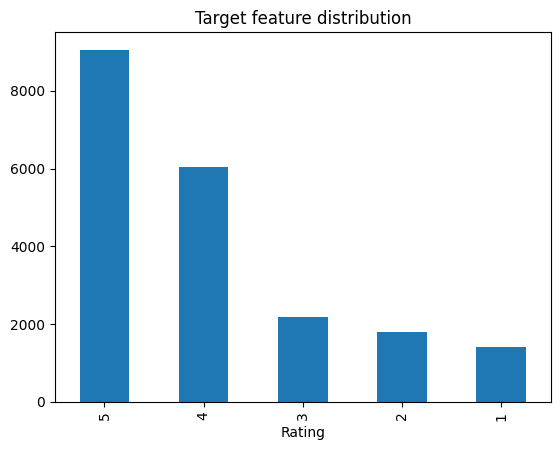

In [71]:
df.Rating.value_counts().plot(kind="bar")

plt.title("Target feature distribution")
plt.show()

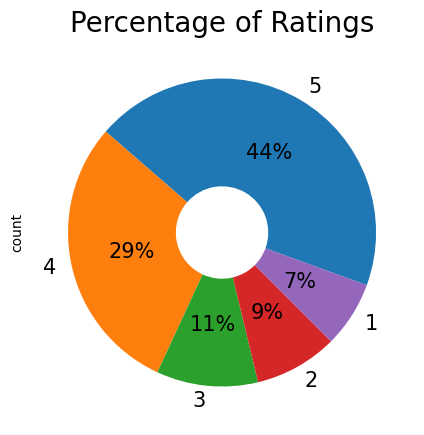

In [72]:
plt.figure(figsize=(5, 5))
plt.title('Percentage of Ratings', fontsize=20)
df.Rating.value_counts().plot(kind='pie',
                              wedgeprops=dict(width=.7), autopct='%1.0f%%', startangle=-20,
                              textprops={'fontsize': 15})

plt.show()

In [73]:
df.Rating.value_counts(sort=True)

Rating
5    9054
4    6039
3    2184
2    1793
1    1421
Name: count, dtype: int64

As we can see, we have an imbalanced dataset, there are far more positive reviews than negative. We will need to make some kind of resampling in order to deal with this problem

As the next step, we'd check the reviews length distribution based on the rating. Firstly, let's add a new feature "Review length"


In [74]:
df["review_length"] = df.Review.apply(lambda x: len(x))

In [75]:
df.head()

,Review,Rating,review_length
0,nice hotel expensive parking got good deal sta...,4,593
1,ok nothing special charge diamond member hilto...,2,1689
2,nice rooms not 4* experience hotel monaco seat...,3,1427
3,"unique, great stay, wonderful time hotel monac...",5,600
4,"great stay great stay, went seahawk game aweso...",5,1281


Great! Let's plot the review length distribution for each Rating

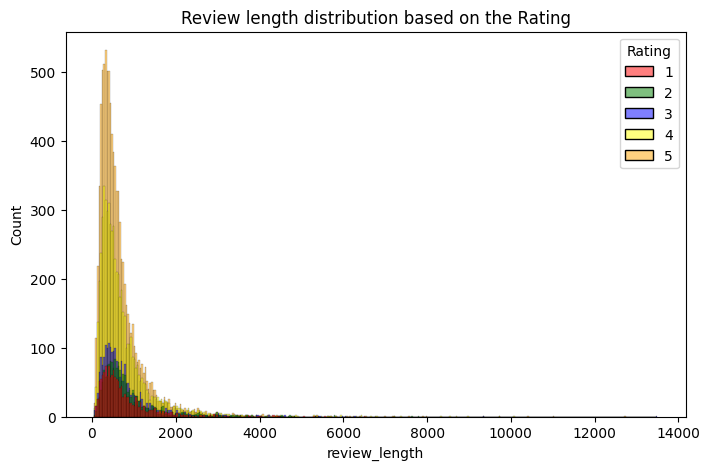

In [76]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8, 5))

sns.histplot(df, x="review_length", hue="Rating", palette=['red', 'green', 'blue', 'yellow', 'orange'], ax=ax)

ax.set_title("Review length distribution based on the Rating")
plt.show()

What we can see on the plot:<br>
1) There is a clear sign of outliers which we will handle later
2) Review length depends on the rating feature. The higher rating, the lengthier is the review

Next, we will see what are the most common words in the reviews

But firstly, let's clean a little bit the text

In [77]:
def text_cleaner(text):
    rules = [
        {r'[^a-zA-Z\s]': u''}, # remove special characters and digits
        {r'>\s+': u'>'},  # remove spaces after a tag opens or closes
        {r'\s+': u' '},  # replace consecutive spaces
        {r'\s*<br\s*/?>\s*': u'\n'},  # newline after a <br>
        {r'</(div)\s*>\s*': u'\n'},  # newline after </p> and </div> and <h1/>...
        {r'</(p|h\d)\s*>\s*': u'\n\n'},  # newline after </p> and </div> and <h1/>...
        {r'<head>.*<\s*(/head|body)[^>]*>': u''},  # remove <head> to </head>
        {r'<a\s+href="([^"]+)"[^>]*>.*</a>': r'\1'},  # show links instead of texts
        {r'[ \t]*<[^<]*?/?>': u''},  # remove remaining tags
        {r'^\s+': u''},  # remove spaces at the beginning
        
    ]
    for rule in rules:
        for (k, v) in rule.items():
            regex = re.compile(k)
            text = regex.sub(v, text)
    text = text.rstrip()
    return text.lower()

In [78]:
df.Review = df.Review.apply(text_cleaner)

In [79]:
reviews_words = [review.split() for review in df['Review']]
allwords = [word for review in reviews_words for word in review]

print(f"The number of words in the dataset is {len(allwords)}")
print(f"The number of unique words in the dataset is {len(set(allwords))}")


The number of words in the dataset is 2090043
The number of unique words in the dataset is 75249


In [80]:
mostcommon = FreqDist(allwords).most_common(100)

wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(20,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words', fontsize=100)
plt.tight_layout(pad=0)
plt.show()